In [4]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yaml
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data from Database

In [5]:
# Helper function to parse config values
def get_config_value(yaml_value, env_var, cast=str):
    env_val = os.getenv(env_var)
    if env_val is not None:
        return cast(env_val)
    if isinstance(yaml_value, str) and yaml_value.startswith("${") and ":" in yaml_value:
        return cast(yaml_value.split(":", 1)[1].rstrip("}"))
    return cast(yaml_value)

# Load database configuration
with open('../config/database.yaml', 'r') as f:
    db_cfg_raw = yaml.safe_load(f)['database']

db_cfg = {
    'host': get_config_value(db_cfg_raw['host'], 'DB_HOST'),
    'port': get_config_value(db_cfg_raw['port'], 'DB_PORT', int),
    'name': get_config_value(db_cfg_raw['name'], 'DB_NAME'),
    'user': get_config_value(db_cfg_raw['user'], 'DB_USER'),
    'password': get_config_value(db_cfg_raw['password'], 'DB_PASSWORD'),
}

# Connect to PostgreSQL database
engine = create_engine(
    f"postgresql+psycopg2://{db_cfg['user']}:{db_cfg['password']}@{db_cfg['host']}:{db_cfg['port']}/{db_cfg['name']}"
)

# Load all data from sensor_data table
df = pd.read_sql("SELECT * FROM sensor_data ORDER BY timestamp;", engine)

print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")

Data loaded successfully!
Shape: (8735, 10)


## 2. Basic Data Inspection

In [6]:
# Display first few rows
print("First 5 rows:")
df.head()

First 5 rows:


,id,timestamp,unix_timestamp,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate,created_at
0,1,2022-06-06 00:29:00+00:00,1654475340,21.63,21.23,47.64,0.005,5.429,0.005,2025-12-10 11:33:33.428277+00:00
1,2,2022-06-06 00:59:00+00:00,1654477140,21.53,21.16,47.78,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00
2,3,2022-06-06 01:29:00+00:00,1654478940,21.44,21.06,48.00,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00
3,4,2022-06-06 01:59:00+00:00,1654480740,21.36,20.98,48.15,0.005,5.286,0.005,2025-12-10 11:33:33.428277+00:00
4,5,2022-06-06 02:29:00+00:00,1654482540,21.29,20.88,48.34,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00


In [7]:
# Data types and non-null counts
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8735 entries, 0 to 8734
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   id                      8735 non-null   int64              
 1   timestamp               8735 non-null   datetime64[ns, UTC]
 2   unix_timestamp          8735 non-null   int64              
 3   temperature_surface     8735 non-null   float64            
 4   temperature_atmosphere  8735 non-null   float64            
 5   relative_humidity       8735 non-null   float64            
 6   cond_low_freq           8735 non-null   float64            
 7   cond_high_freq          8735 non-null   float64            
 8   corrosion_rate          8735 non-null   float64            
 9   created_at              8735 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(6), int64(2)
memory usage: 682.5 KB


In [8]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,id,unix_timestamp,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate
count,8735.000000,8.735000e+03,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000
mean,4368.000000,1.662336e+09,24.089697,24.488044,67.171786,0.335189,41.933520,0.044904
std,2521.721634,4.539099e+06,10.719266,11.590126,28.042658,0.386367,203.100755,0.168994
min,1.000000,1.654475e+09,-4.150000,-4.350000,5.170000,0.005000,5.000000,0.005000
25%,2184.500000,1.658406e+09,16.770000,16.480000,42.990000,0.038700,5.000000,0.005000
50%,4368.000000,1.662336e+09,24.150000,23.830000,75.430000,0.123200,5.000000,0.005000
75%,6551.500000,1.666266e+09,30.050000,31.130000,91.710000,0.633950,5.214000,0.005000
max,8735.000000,1.670197e+09,57.830000,59.340000,100.000000,1.000000,4252.000000,3.875000


In [9]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []


## 3. Time Series Analysis

In [10]:
# Check time range
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")
print(f"Total records: {len(df)}")

Time range: 2022-06-06 00:29:00+00:00 to 2022-12-04 23:29:00+00:00
Duration: 181 days 23:00:00
Total records: 8735


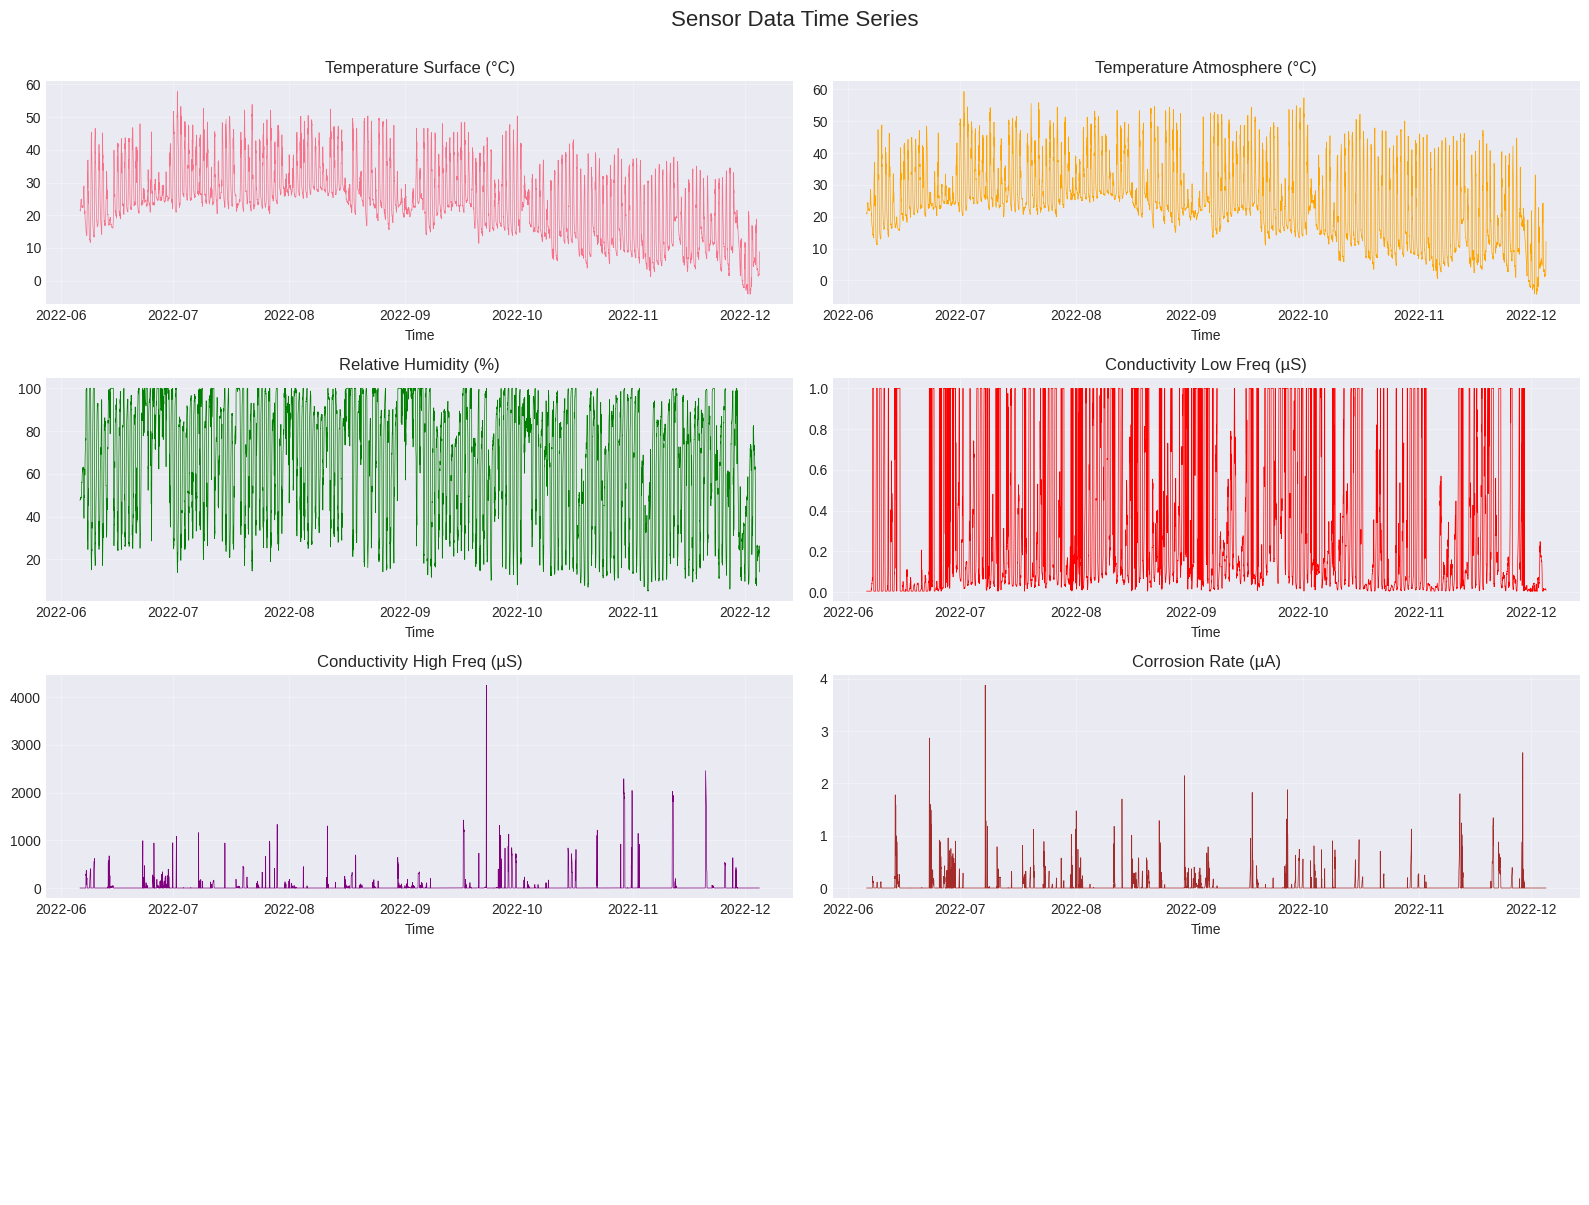

In [11]:
# Plot all sensor variables over time
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle('Sensor Data Time Series', fontsize=16, y=1.00)

# Temperature Surface
axes[0, 0].plot(df['timestamp'], df['temperature_surface'], linewidth=0.5)
axes[0, 0].set_title('Temperature Surface (°C)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].grid(True, alpha=0.3)

# Temperature Atmosphere
axes[0, 1].plot(df['timestamp'], df['temperature_atmosphere'], linewidth=0.5, color='orange')
axes[0, 1].set_title('Temperature Atmosphere (°C)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].grid(True, alpha=0.3)

# Relative Humidity
axes[1, 0].plot(df['timestamp'], df['relative_humidity'], linewidth=0.5, color='green')
axes[1, 0].set_title('Relative Humidity (%)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].grid(True, alpha=0.3)

# Conductivity Low Frequency
axes[1, 1].plot(df['timestamp'], df['cond_low_freq'], linewidth=0.5, color='red')
axes[1, 1].set_title('Conductivity Low Freq (µS)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)

# Conductivity High Frequency
axes[2, 0].plot(df['timestamp'], df['cond_high_freq'], linewidth=0.5, color='purple')
axes[2, 0].set_title('Conductivity High Freq (µS)')
axes[2, 0].set_xlabel('Time')
axes[2, 0].grid(True, alpha=0.3)

# Corrosion Rate
axes[2, 1].plot(df['timestamp'], df['corrosion_rate'], linewidth=0.5, color='brown')
axes[2, 1].set_title('Corrosion Rate (µA)')
axes[2, 1].set_xlabel('Time')
axes[2, 1].grid(True, alpha=0.3)

# Hide empty subplots
axes[3, 0].axis('off')
axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

## 4. Distribution Analysis

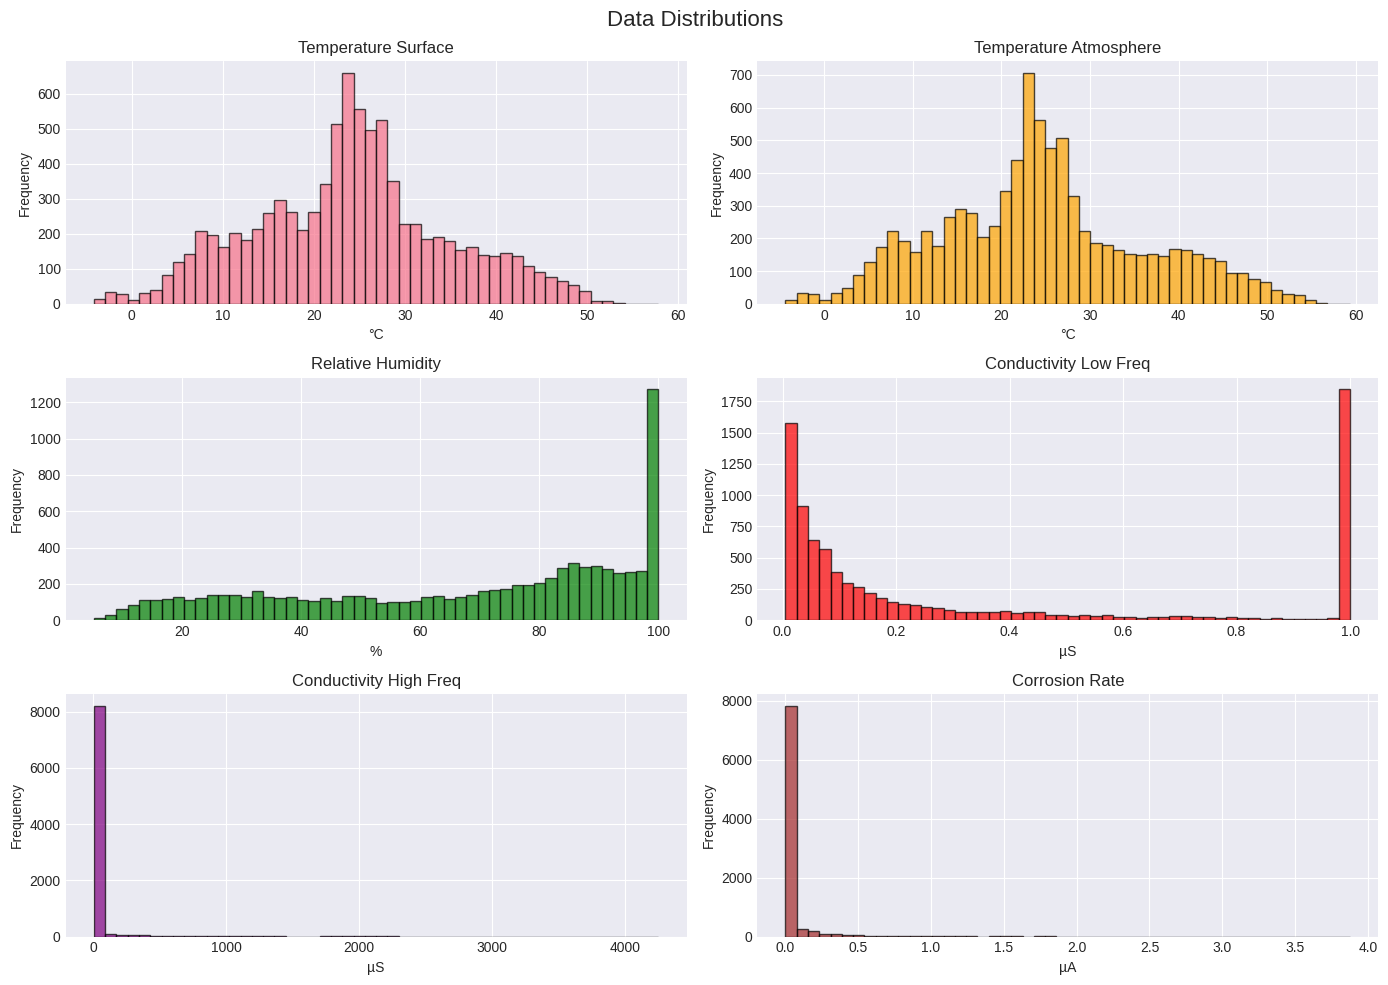

In [12]:
# Distribution histograms for all sensor variables
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Data Distributions', fontsize=16)

# Temperature Surface
axes[0, 0].hist(df['temperature_surface'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Temperature Surface')
axes[0, 0].set_xlabel('°C')
axes[0, 0].set_ylabel('Frequency')

# Temperature Atmosphere
axes[0, 1].hist(df['temperature_atmosphere'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Temperature Atmosphere')
axes[0, 1].set_xlabel('°C')
axes[0, 1].set_ylabel('Frequency')

# Relative Humidity
axes[1, 0].hist(df['relative_humidity'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Relative Humidity')
axes[1, 0].set_xlabel('%')
axes[1, 0].set_ylabel('Frequency')

# Conductivity Low Frequency
axes[1, 1].hist(df['cond_low_freq'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Conductivity Low Freq')
axes[1, 1].set_xlabel('µS')
axes[1, 1].set_ylabel('Frequency')

# Conductivity High Frequency
axes[2, 0].hist(df['cond_high_freq'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2, 0].set_title('Conductivity High Freq')
axes[2, 0].set_xlabel('µS')
axes[2, 0].set_ylabel('Frequency')

# Corrosion Rate
axes[2, 1].hist(df['corrosion_rate'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[2, 1].set_title('Corrosion Rate')
axes[2, 1].set_xlabel('µA')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

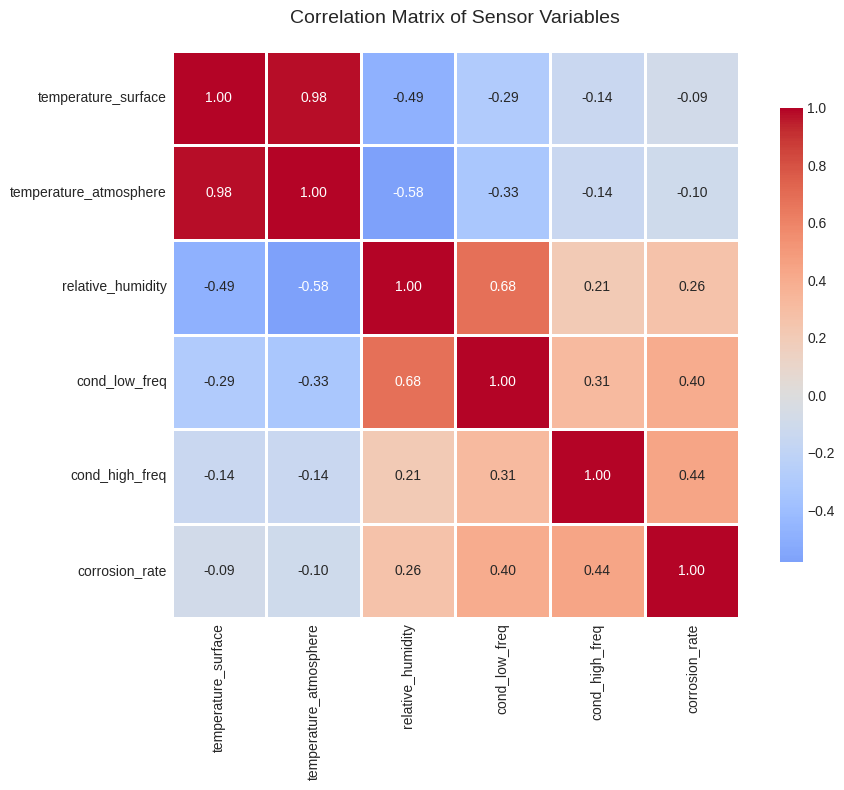

In [13]:
# Select numeric columns for correlation
numeric_cols = ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 
                'cond_low_freq', 'cond_high_freq', 'corrosion_rate']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Sensor Variables', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [14]:
# Print correlation with corrosion rate
print("Correlation with Corrosion Rate:")
print(corr_matrix['corrosion_rate'].sort_values(ascending=False))

Correlation with Corrosion Rate:
corrosion_rate            1.000000
cond_high_freq            0.439035
cond_low_freq             0.395855
relative_humidity         0.262838
temperature_surface      -0.090065
temperature_atmosphere   -0.101517
Name: corrosion_rate, dtype: float64


## 6. Outlier Detection

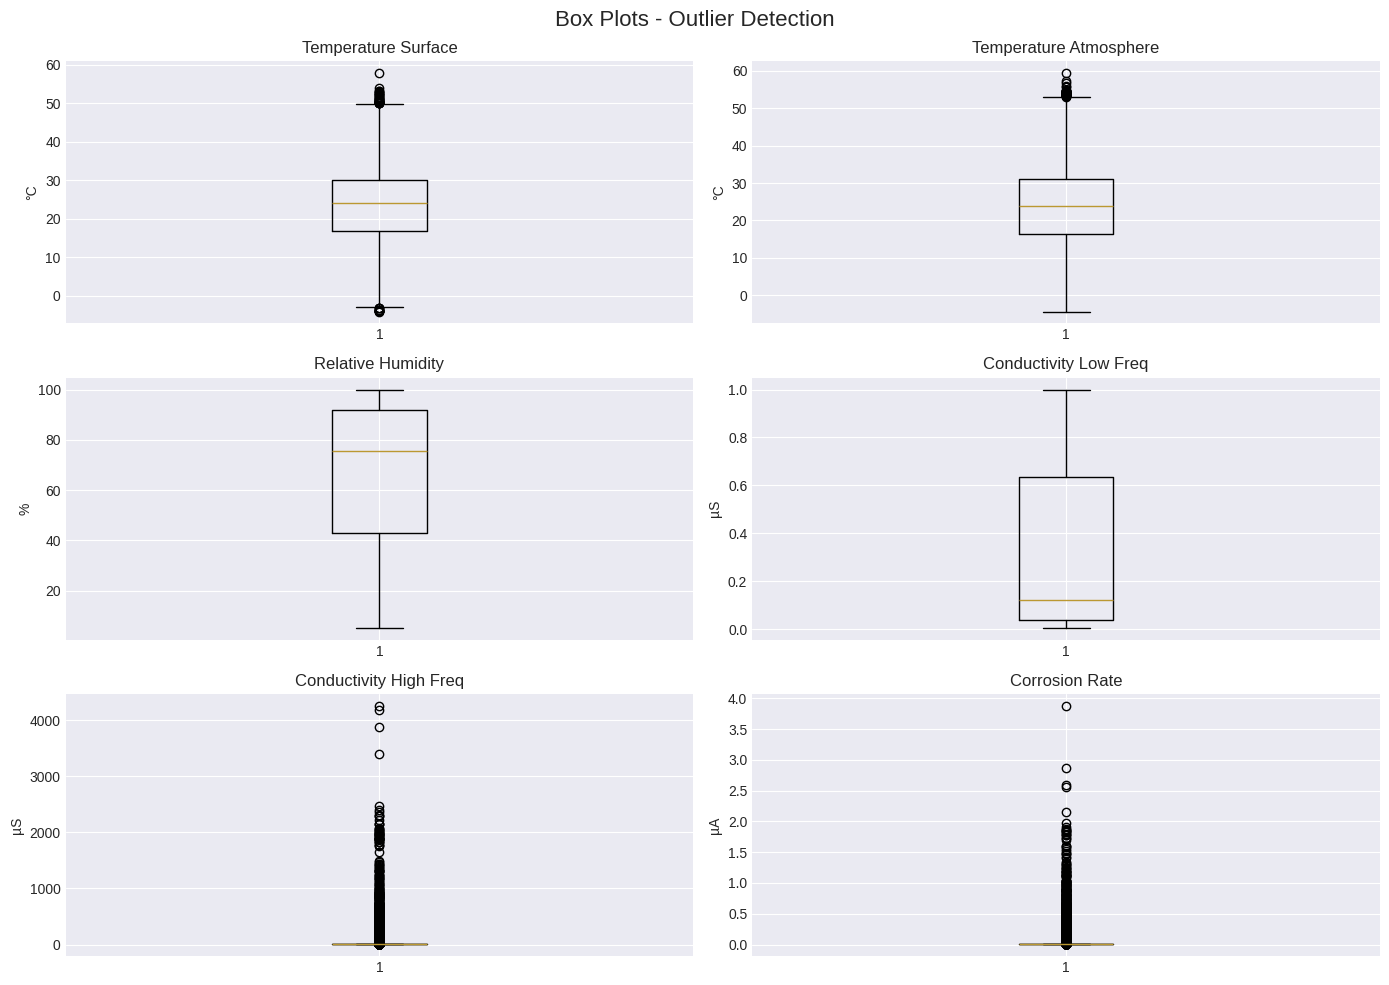

In [15]:
# Box plots to identify outliers
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16)

axes[0, 0].boxplot(df['temperature_surface'].dropna())
axes[0, 0].set_title('Temperature Surface')
axes[0, 0].set_ylabel('°C')

axes[0, 1].boxplot(df['temperature_atmosphere'].dropna())
axes[0, 1].set_title('Temperature Atmosphere')
axes[0, 1].set_ylabel('°C')

axes[1, 0].boxplot(df['relative_humidity'].dropna())
axes[1, 0].set_title('Relative Humidity')
axes[1, 0].set_ylabel('%')

axes[1, 1].boxplot(df['cond_low_freq'].dropna())
axes[1, 1].set_title('Conductivity Low Freq')
axes[1, 1].set_ylabel('µS')

axes[2, 0].boxplot(df['cond_high_freq'].dropna())
axes[2, 0].set_title('Conductivity High Freq')
axes[2, 0].set_ylabel('µS')

axes[2, 1].boxplot(df['corrosion_rate'].dropna())
axes[2, 1].set_title('Corrosion Rate')
axes[2, 1].set_ylabel('µA')

plt.tight_layout()
plt.show()

## 7. Data Quality Summary

In [16]:
# Summary statistics for data quality
print("=" * 60)
print("DATA QUALITY SUMMARY")
print("=" * 60)
print(f"\nTotal Records: {len(df)}")
print(f"Time Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nMissing Values:")
for col in numeric_cols:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")

print(f"\nData Ranges:")
for col in numeric_cols:
    print(f"  {col}: [{df[col].min():.2f}, {df[col].max():.2f}]")

print("\n" + "=" * 60)

DATA QUALITY SUMMARY

Total Records: 8735
Time Period: 2022-06-06 00:29:00+00:00 to 2022-12-04 23:29:00+00:00

Missing Values:
  temperature_surface: 0 (0.00%)
  temperature_atmosphere: 0 (0.00%)
  relative_humidity: 0 (0.00%)
  cond_low_freq: 0 (0.00%)
  cond_high_freq: 0 (0.00%)
  corrosion_rate: 0 (0.00%)

Data Ranges:
  temperature_surface: [-4.15, 57.83]
  temperature_atmosphere: [-4.35, 59.34]
  relative_humidity: [5.17, 100.00]
  cond_low_freq: [0.01, 1.00]
  cond_high_freq: [5.00, 4252.00]
  corrosion_rate: [0.01, 3.88]

